In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn

In [5]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [8]:
num_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[num_features] = all_features[num_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[num_features] = all_features[num_features].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True) #将缺失值视作有效的特征值，并为其创建指示符特征
all_features.shape

(2919, 330)

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32) #.values将数据转成numpy便于处理
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
#将标签转成二维向量

In [45]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
hidden_units = 256
def get_net():
    net = nn.Sequential(
    nn.Linear(in_features, hidden_units),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden_units, 1)
)
    return net
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [30]:
#当关注相对误差时，经常考虑对数rmse
def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.clamp(net(features), 1, float('inf')) #torch.clamp(input, min=None, max=None) 用来限制张量的范围
        rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [14]:
from torch.utils.data import Dataset, DataLoader

class HousePriceDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [24]:
#使用Adam优化器
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_dataset = HousePriceDataset(train_features, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [19]:
#实现绘图函数
import matplotlib.pyplot as plt

def plot_log_rmse(train_ls, valid_ls, num_epochs):
    """
    画出训练集与验证集的 log rmse 曲线
    """
    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_ls, label='train', marker='o')
    plt.plot(epochs, valid_ls, label='valid', marker='s')
    plt.xlabel('epoch')
    plt.ylabel('log rmse')
    plt.yscale('log')  # y轴对数尺度
    plt.xlim([1, num_epochs])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.title('Training and Validation Log RMSE')
    plt.tight_layout()
    plt.show()

In [32]:
#k折交叉验证
#划分第i折数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k #每一折的大小
    X_train, y_train = None, None

    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) #slice获取行切片的索引范围
        X_part, y_part = X[idx, :], y[idx]

        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], dim=0) #在行的维度进行追加
            y_train = torch.cat([y_train, y_part], dim=0)

    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0

    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        net.apply(init_weights)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
    #第一折画图
        if i == 0:
            plot_log_rmse(train_ls, valid_ls, num_epochs)
        print(f'折 {i + 1}，训练 log rmse: {float(train_ls[-1]):.6f}, '
              f'验证 log rmse: {float(valid_ls[-1]):.6f}')

    return train_l_sum / k, valid_l_sum / k

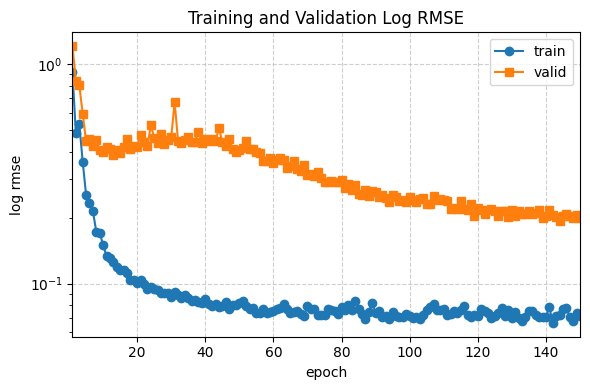

折 1，训练 log rmse: 0.071257, 验证 log rmse: 0.200126
折 2，训练 log rmse: 0.077515, 验证 log rmse: 0.217198
折 3，训练 log rmse: 0.070892, 验证 log rmse: 0.288132
折 4，训练 log rmse: 0.072513, 验证 log rmse: 0.185062
折 5，训练 log rmse: 0.066714, 验证 log rmse: 0.235553
5-折验证: 平均训练log rmse: 0.071778, 平均验证log rmse: 0.225214


In [54]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 1, 1e-4, 256
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
 f'平均验证log rmse: {float(valid_l):f}')

In [58]:
#使用所有数据
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs=150, lr=1, weight_decay=1e-4, batch_size=256):
    net = get_net()
    net.apply(init_weights)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)

    # 可视化 log rmse 曲线
    plt.figure(figsize=(6,4))
    plt.plot(range(1, num_epochs + 1), train_ls, label='train log rmse')
    plt.xlabel('epoch')
    plt.ylabel('log rmse')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f'最终训练 log rmse：{float(train_ls[-1]):f}')

    # 预测
    net.eval()
    preds = net(test_features).detach().numpy()

    # 生成提交文件
    test_data['SalePrice'] = pd.Series(preds.reshape(-1))
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('../data/submission.csv', index=False)
    print("已生成 submission.csv")

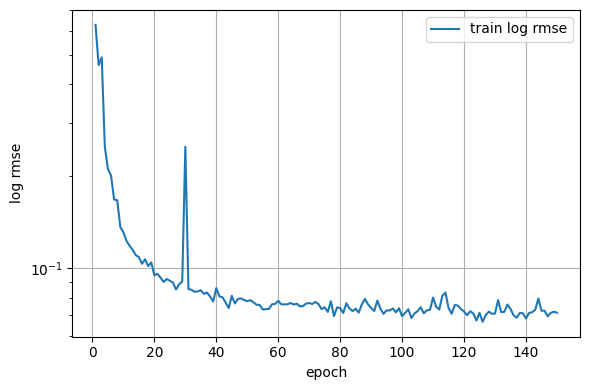

最终训练 log rmse：0.071425
已生成 submission.csv


In [59]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)